# Detecting event boundaries for newly learned event sequences
    
In statistical learning (SL) paradigms participants are continuously and repeatedly shown items (e.g., novel objects) with little to no semantic or perceptual differences from one another. During passive viewing, participants are able to form these items into groups i.e., events, based purely on shared co-occurrences between items across repeated exposures. Knowledge of these events is measured with a surprise recognition test after passive exposure. While this test has proven to reflect participants' familiarity with events it has 2 important limitations. 
    
1) Because participants can solve the recognition test with multiple strategies it doesn’t probe the specificity of participants' event knowledge

2) Because there is no behavioral index of event knowledge during learning it can’t provide insight into how participants are actually forming event knowledge across repetitions. 

These paradigms are powerful because they allow the researcher to probe the capacity to take continuous experience and form discrete events by detecting patterns across repeated experiences. We are proposing a new measure that will allow us to probe the specificity of event knowledge after learning and detect the formation of event knowledge during learning.

Here we will pose a series of questions.
1) What is the probability participants are able to indicate the beginning and end of events when presented in a stream.

### modules/functions

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pingouin as pg

def correct_resp(r):
    """ 
    Description
    -----------
    
    Determines what the correct response should be on
    the left (1), or right (2) side of the screen based 
    on image 1 in the pattern game. 
    
    In the pattern game, image 1 indicates the start
    of a new triplet. In the remember game, image 1 is
    presented on either the left or right side of the screen.
    Participants must indicate whether they believe the left
    or right side of the screen showed the triplet from the
    pattern game. Therefore, this function determines if 
    image 1 in the remember game (which is the row input here) 
    is the same as image 1 from the pattern game i.e., 
    "i1_pattern_game" AND determine which side this image 1
    was presented. This function returns the correct side of
    the screen the participant should have responded for a 
    given trial, left (1) or right (2).
    
    
    Input
    -----
    Row information for a particular trial
    
    
    Returns
    -------
    A 1 or 2 indicating whether the correct response 
    for a particular trial is on the left (1) or 
    right (2) side of the screen.
    
    """
    # 1 or 0 - is image 1 in remember game the same as image 1 in
    # the pattern game?
    i1_pattern = r['pattern_game']     
    
    ## 1 left, 2 right - was image 1 presented on the left or
    # right side of the screen?
    i1_side = r['l_or_r']
    
    # if image 1 remember is the same as the pattern and presented
    # on the left side of the screen then the left side i.e., 1
    # is correct -- this binary logic carries out below.
    if (i1_pattern == 1 and i1_side == 1):
        correct = 1
    elif (i1_pattern == 1 and i1_side == 2):
        correct = 2
    elif (i1_pattern == 0 and i1_side == 1):
        correct = 2
    elif (i1_pattern == 0 and i1_side == 2):
        correct = 1
    return correct

/Users/anthonydutcher/anaconda3/envs/TA/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/anthonydutcher/anaconda3/envs/TA/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### pattern game data import and cleaning (wide to long format)

In [4]:
# pattern game
pat = pd.read_csv('data/temple_pattern_all_participants_2021-05-24_cleaned.csv')
pat.drop(['date', 'OS'], axis=1, inplace=True)

# remove bad participant
pat = pat[pat.participant!=1]

# remap keys for plotting purposes
pat['image1_key_resp.keys'].replace(to_replace={'f':'begin', 'j':'end'}, inplace = True)
pat['image2_key_resp.keys'].replace(to_replace={'f':'begin', 'j':'end'}, inplace = True)
pat['image3_key_resp.keys'].replace(to_replace={'f':'begin', 'j':'end'}, inplace = True)
pat['image1_key_resp.keys'].replace(to_replace={'f,j':'begin', 'j,f':'end'}, inplace = True)
pat['image2_key_resp.keys'].replace(to_replace={'f,j':'begin', 'j,f':'end'}, inplace = True)
pat['image3_key_resp.keys'].replace(to_replace={'f,j':'begin', 'j,f':'end'}, inplace = True)

# get the true pattern (from pattern game) and set to correct
true = pat[['participant','image1','image2','image3']].drop_duplicates()
n_participants = len(true.participant.unique())

# gets the 'true' triads from pattern game for the remember game
true['triad'] = np.tile([1, 2, 3, 4], n_participants)
true['pattern_game'] = 1
pat = pat.merge(true, how='outer', on=['participant','image1','image2','image3']).sort_values(['participant','trial'])

# transitioning data from wide format to long format.
id_vars = ['trial', 'participant', 'triad']

# a trial (row) in psychopy has three image responses (columns)
un_pivot_vars1 = ['image1_key_resp.keys', 'image2_key_resp.keys','image3_key_resp.keys']
un_pivot_vars2 = ['image1_key_resp.rt', 'image2_key_resp.rt','image3_key_resp.rt']
un_pivot_vars3 = ['image1', 'image2', 'image3']

# moves from three columns per trial to three rows per trial 
# in separate dataframes (one per row)
up1 = pat[ id_vars + un_pivot_vars1 ].melt(id_vars = id_vars, value_vars = un_pivot_vars1, 
                                           var_name = 'old_var1', value_name = 'indication').sort_values(['participant','trial']).drop('old_var1', axis=1)
up2 = pat[ id_vars + un_pivot_vars2 ].melt(id_vars = id_vars, value_vars = un_pivot_vars2,
                                           var_name = 'old_var2', value_name = 'rt').sort_values(['participant','trial']).drop('old_var2', axis=1)
up3 = pat[ id_vars + un_pivot_vars3 ].melt(id_vars = id_vars, value_vars = un_pivot_vars3,
                                           var_name = 'old_var3', value_name = 'image id').sort_values(['participant','trial']).drop('old_var3', axis=1)

# indicates the position for each of the data frames
up1['position'] = np.tile(['1', '2', '3'], int(len(up1)/3))
up2['position'] = np.tile(['1', '2', '3'], int(len(up2)/3))
up3['position'] = np.tile(['1', '2', '3'], int(len(up3)/3))

# merges based oon trials, participant and position
t1 = pd.merge(up1, up2, how="inner", on=['trial', 'participant', 'position','triad'])
pdf = pd.merge(t1, up3, how="inner", on=['trial', 'participant', 'position','triad'])

# did they indicate either a start or end to a triplet?
pdf['key press'] = (~pdf[['indication']].isnull()) * 1

# this resets trials to be for each image and not triplet
# i.e., 1 to 3, for the long format
total_keys = ((pdf[['participant', 'trial']].groupby(['participant']).max()+1)*3).to_dict()['trial']
x = []
for key, val in total_keys.items():
    y = pd.DataFrame(np.vstack([np.repeat(key, val), np.arange(val)])).T
    y.columns = ['participant','i trial']
    x.append(y)
z = pd.concat(x)
pdf['i trial'] = z['i trial'].values + 1

# save
pdf.to_csv('data/temple_bound_long_format.csv')
participants = pdf.participant.unique()

### turn counts to probabilities

In [5]:
# binarize 'begin' and 'end' as separate variables to generate probabilities
pdf['begin'] = (pdf.indication == 'begin') * 1
pdf['end'] = (pdf.indication == 'end') * 1

# probabilities for end (by triad)
ppdf = pdf.query("position=='3'")
button_prob_end = ppdf[['participant','position','indication','triad','end']].groupby(['participant','triad']).mean()# probabilities for end

# probabilities for begin (by triad)
ppdf = pdf.query("position=='1'")
button_prob_begin = ppdf[['participant','position','indication','triad','begin']].groupby(['participant','triad']).mean()

# merge into single df and join with triplet detection data -- save out
button_prob = button_prob_begin.join(button_prob_end)
button_prob.reset_index().to_csv('data/button_prob.csv', index=False)
bp = button_prob.reset_index()

# Can participants detect event boundaries in a continuous stream?

After viewing a stream of objects for ~5 minutes (with triplet structure), we presented the same structure again and asked participants to indicate the beginning and end of triplet events.

Specfically, we told participants that they will view a stream of objects and that a pattern exists in the stream of objects and that we want them to pick out these patterns. We walked participants through a few examples of streams with pairs (X1 → X2) and quadruplets (X1 → X2 → X3 → X4). We instructed them to press a button when they think a pattern is beginning and a different button when they think a pattern is ending. 

If participants can detect events we would expect participants to indicate a 'begin' press at the start of a triplet and an 'end' press at the end of a triplet.



Integrated objects will be operationalized as all the objects from the ‘1’ button press up to the ‘2’ button press. An event boundary will be operationalized as a ‘2’ button press followed by a ‘1’ button press. We expect participants to successfully integrate object pairs and triplets before detecting event boundaries.

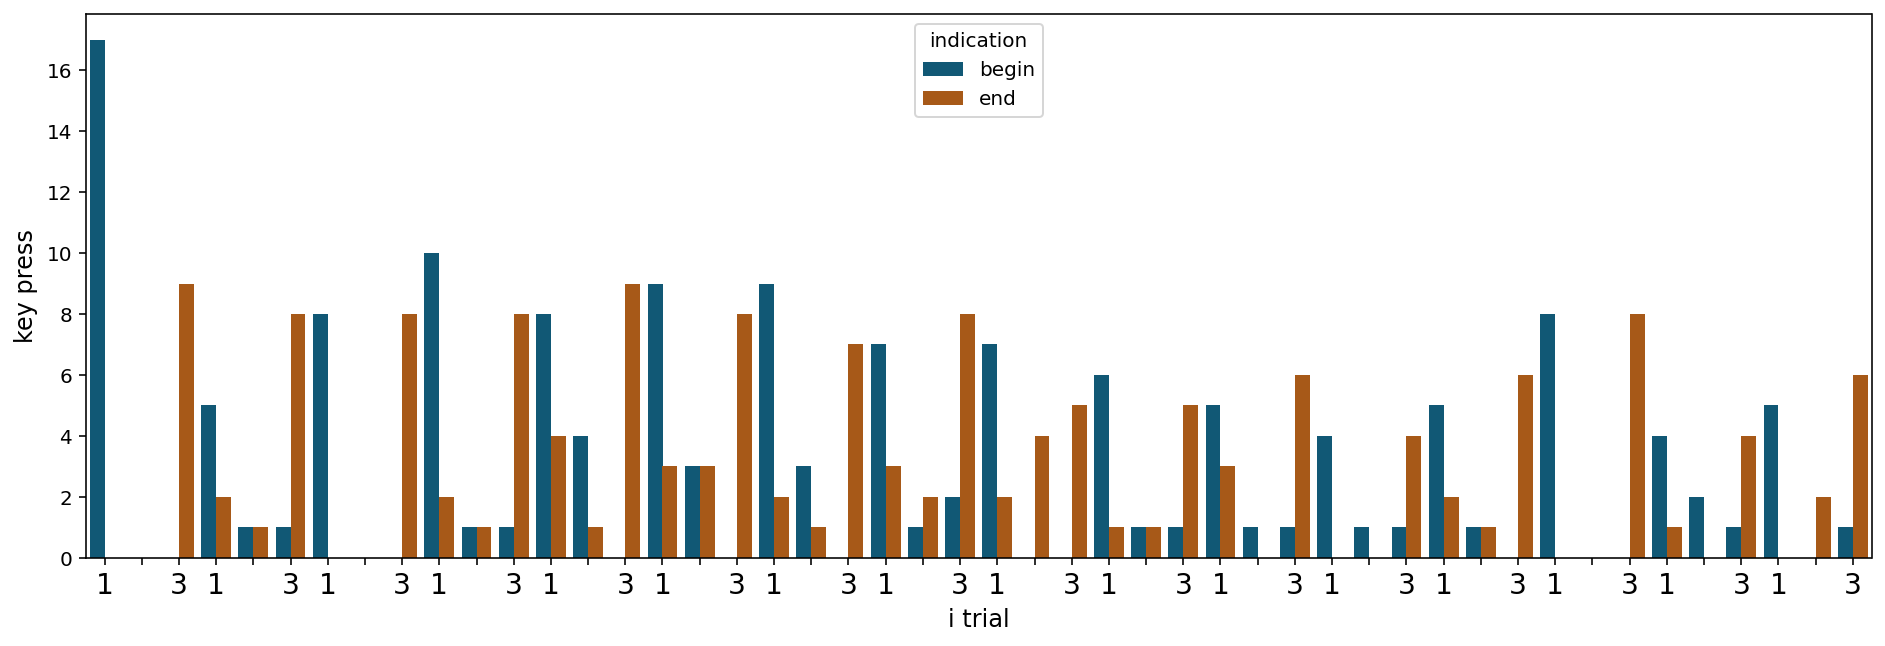

In [41]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['figure.figsize'] = (16,5)
c_pal = ["#005f86", '#bf5700']
totals = pdf[['participant', 'i trial', 'indication', 'key press']].groupby(['indication', 'i trial']).sum().reset_index()
g = sns.barplot(x="i trial", y="key press", hue='indication', 
                palette=c_pal, 
                order=np.arange(1,pdf.loc[:,'i trial'].max()+1), data=totals)
g.set_xticklabels(np.tile(['1', '', '3'], int(48/3)), size=14)
None

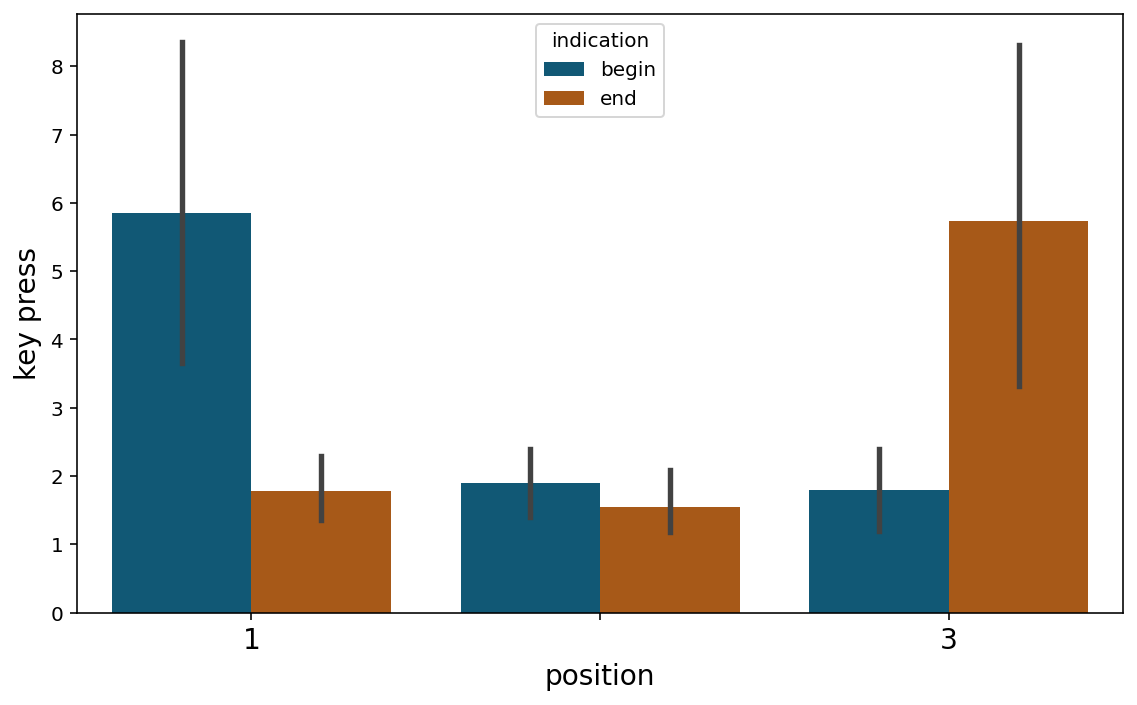

In [63]:
plt.rcParams['figure.figsize'] = (8,5)
totals = pdf[['participant', 'position', 'indication', 'key press']].groupby(['participant', 'indication', 'position']).count().reset_index()
g = sns.barplot(x="position", y="key press", hue='indication', 
                palette=c_pal, order=['1', '2', '3'], data=totals)
g.set_xticklabels(['1', '', '3'], size=14)
plt.tight_layout()
None

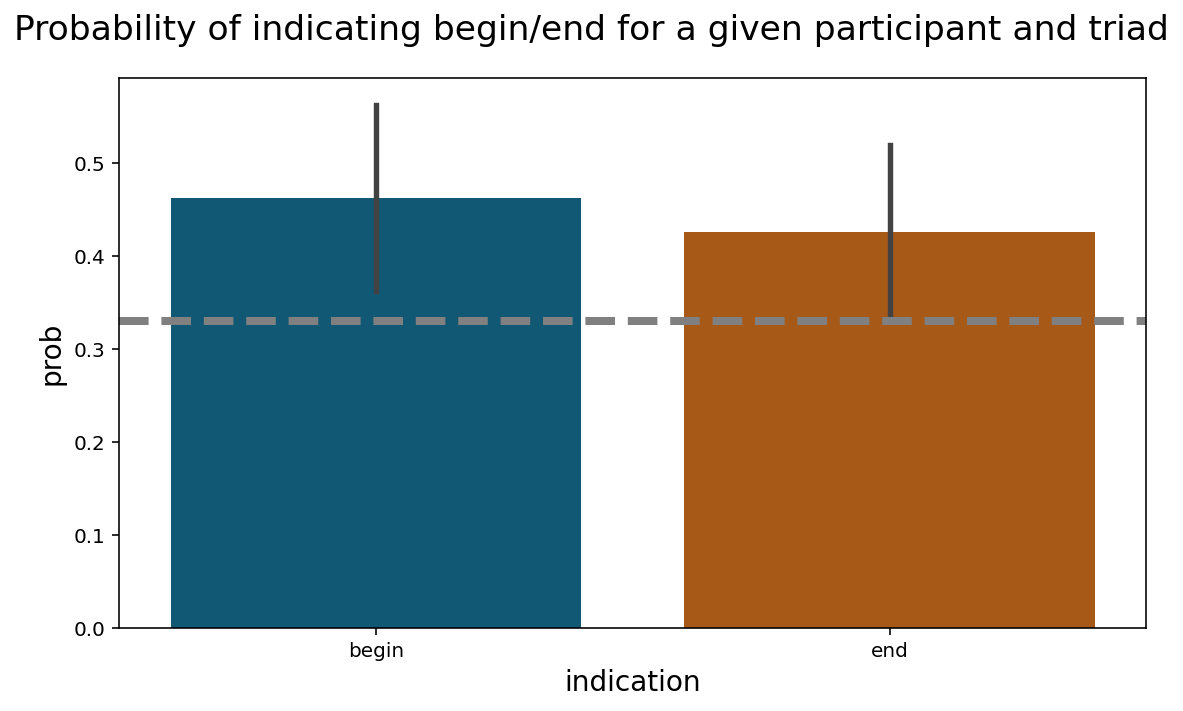

In [62]:
plt.rcParams['figure.figsize'] = (8,5)
id_vars = ['participant', 'triad']
pbp = bp.melt(id_vars=id_vars, var_name='indication', value_name='prob')
g = sns.barplot(dodge=True, x="indication", y="prob", 
                palette=c_pal, data=pbp)
g.figure.suptitle("Probability of indicating begin/end for a given participant and triad")
g.axhline(0.33, color='gray', lw=4, linestyle='--')
plt.tight_layout()
None

In [53]:
btest = pg.ttest(bp.begin, .33)
btest['test'] = 'beginning'
etest = pg.ttest(bp.end, .33)
etest['test'] = 'ending'
pd.concat([btest, etest])

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power,test
T-test,2.65315,79,two-sided,0.009637,"[0.36, 0.56]",0.296631,3.227,0.745635,beginning
T-test,1.96314,79,two-sided,0.053149,"[0.33, 0.52]",0.219486,0.762,0.491786,ending


### Summary

It appears detecting the start of a triplet is significant (p <0.01) and the end of a triplet is nearly signficant (p < 0.054). 

#### Next steps
- This could be better powered with more participants.
- This doesn't answer if participants are detecting full triplet 'events'. This is to be completed. 


## The triplet detection task (remembering game)

In [60]:
# remember
rem = pd.read_csv('data/temple_remember_all_participants_2021-05-24_cleaned.csv')
rem.drop(['date', 'OS'], axis=1, inplace=True)
rem = rem[rem.participant!=1]

# merge the correct trial indication and the triad id with remember responses 
rem_clean = rem.merge(true, how='outer', on=['participant','image1','image2','image3']).sort_values(['participant','trial'])
rem_clean.loc[rem_clean['pattern_game'].isnull(), 'pattern_game'] = 0
rem_clean.loc[rem_clean['triad'].isnull(), 'triad'] = 0

# apply correct response on screen side function (see above)
rem_clean['correct_resp'] = rem_clean.apply(correct_resp, axis=1)

# this gets the triad id for the offset rows (when correct is image 4, 5, 6)
true_off = true.rename(columns={'image1':'image4','image2':'image5','image3':'image6','triad':'triad_2'})

# drops old i1_patten so it doesn't merge
true_off.drop(axis=1, labels=['pattern_game'], inplace=True) 

# merges pattern game true triad from pattern game for image 4, 5, 6, in remember game
rdf = rem_clean.merge(true_off, how='outer', on=['participant','image4','image5','image6']).sort_values(['participant','trial'])
rdf.loc[rdf['triad_2'].isnull(), 'triad_2'] = 0
rdf.rename(columns={'triad':'triad_1'}, inplace=True)

# collapse index for true triad id for all images in the remember to single column
rdf['triad'] = rdf.triad_2.to_numpy() + rdf.triad_1.to_numpy()
rdf.drop(axis=1, columns=['triad_1','triad_2','pattern_game'], inplace=True)

# correct response based on side correct response exists and participant response
rdf['accuracy'] = (rdf.correct_resp.to_numpy() == rdf[['key_resp_2.keys']].to_numpy().squeeze()) * 1
rdf.to_csv('data/temple_bound_remember_clean.csv', index=False)

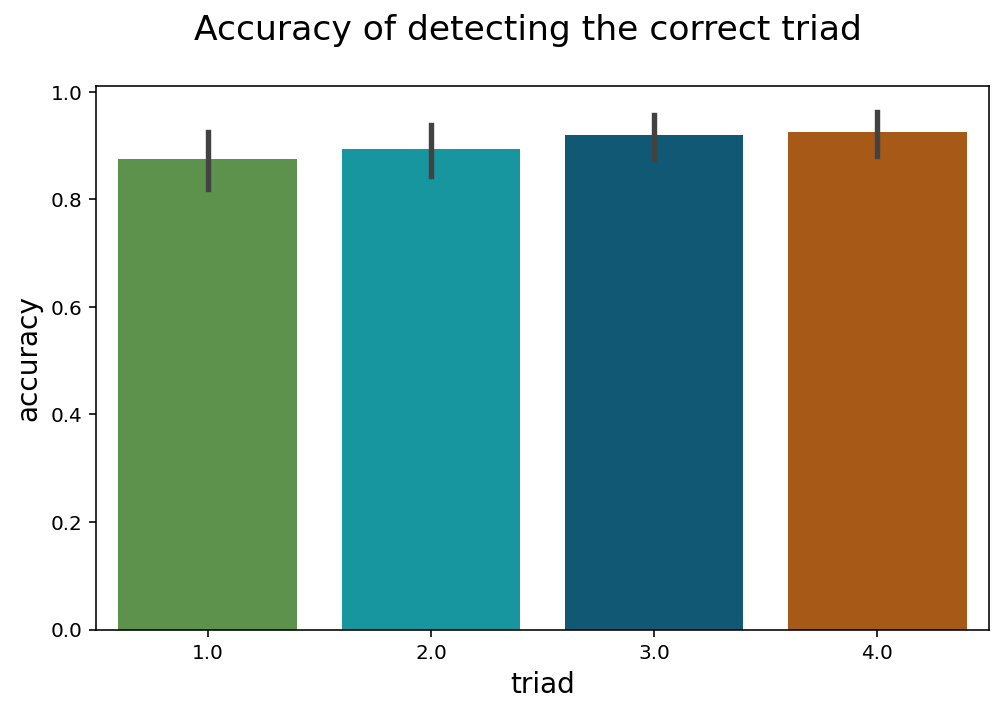

In [76]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.titlesize'] = 'xx-large'
cmap4 = ["#579d42", "#00a9b7", "#005f86", '#bf5700']
g = sns.barplot(x='triad', y='accuracy', palette=cmap4, data=rdf.query("triad>0"))
g.figure.suptitle("Accuracy of detecting the correct triad")
None

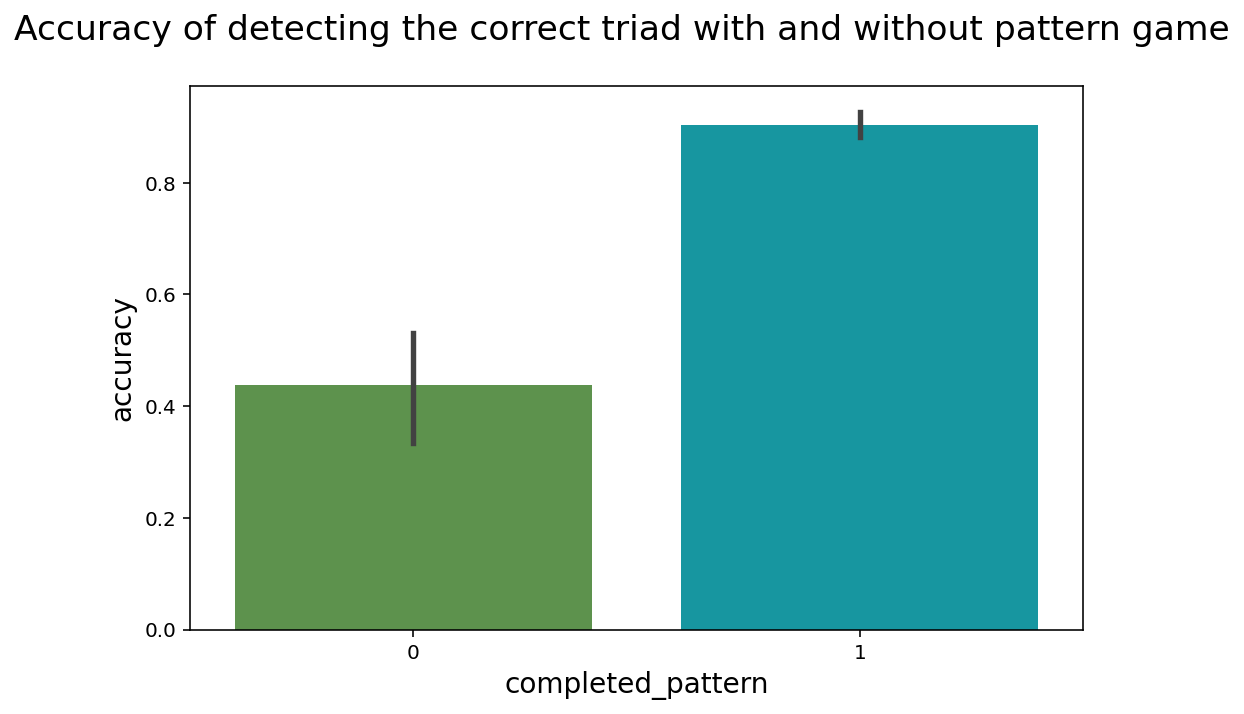

In [80]:
rdf['completed_pattern'] = rdf.eval("triad>0") * 1
g = sns.barplot(x='completed_pattern', y='accuracy', palette=cmap4[:2], data=rdf)
g.figure.suptitle("Accuracy of detecting the correct triad with and without pattern game")
None

### Summary 
It would seem participants learn from the pattern game and therefore we don't seem to have a clearn measure of triplet detection without alerting participants that a pattern exists. Nonetheless, next we will look at the relationship between these things.

## Combine pattern game and triplet detection task.
Does the probability of indicating a pattern beginning or a pattern ending during the pattern game predict participants ability to detect that specific triplet during the triplet detectioon task?

In [82]:
fdf = rdf.merge(bp, how='outer', on=['participant','triad']).sort_values(['participant', 'trial'])
fdf.to_csv('data/temple_bound_remember_pat_prob.csv', index=False)

In [83]:
# isolate appropriate data for plotting relationship between beginning and ending
# indications relationship to memory during triplet detection
df = fdf[['participant','triad','accuracy','begin','end']].reset_index(drop=True)
df = df.query("triad != 0")
data = df.copy()

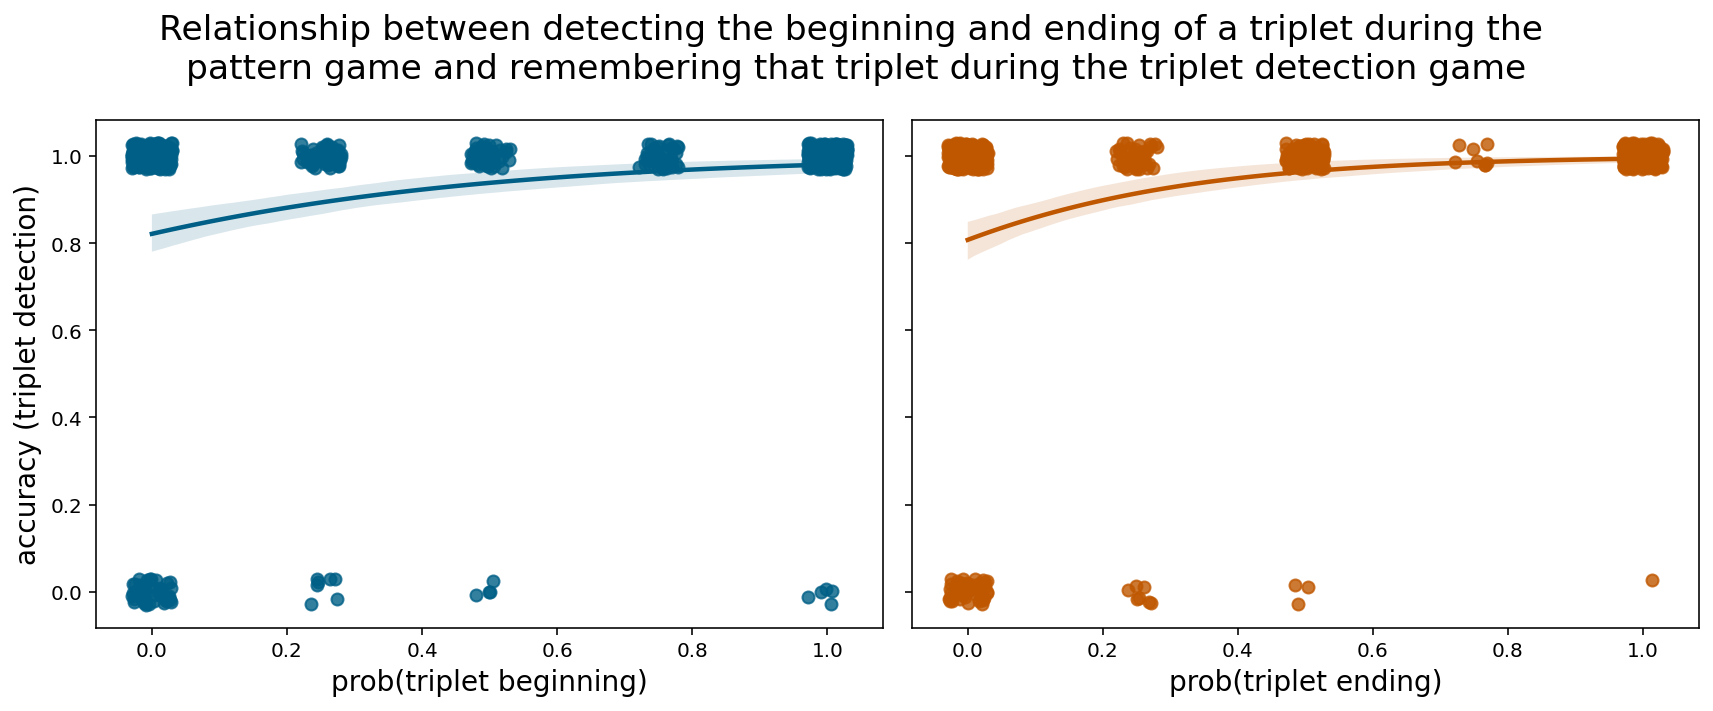

In [84]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.titlesize'] = 'xx-large'
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)
fig.suptitle("Relationship between detecting the beginning and ending of a triplet during the \npattern game and remembering that triplet during the triplet detection game")
sns.regplot(ax=ax[0], x='begin', y='accuracy', data=data,  
            fit_reg=True, logistic=True, scatter=True, 
            y_jitter=.03, x_jitter=.03, color=c_pal[0])
ax[0].set_xlabel('prob(triplet beginning)')
ax[0].set_ylabel('accuracy (triplet detection)')
sns.regplot(ax=ax[1], x='end', y='accuracy', data=data, 
            fit_reg=True, logistic=True, scatter=True,
            y_jitter=.03, x_jitter=.03, color=c_pal[1])
ax[1].set_xlabel('prob(triplet ending)')
ax[1].set_ylabel('')
plt.tight_layout()

### Summary
There appears to be a relationship but it is tricky to isolate and test cleanly.

In [ ]:
# participant level - very messy plots
# id_vars = ['participant', 'triad']
# pdata = data.melt(id_vars=id_vars, var_name='indication', value_name='prob')
# sns.lmplot(data=pdata, logistic=True, palette = ['orange', 'purple'],
#            x='prob', y='accuracy', col='participant', 
#            y_jitter=.03, x_jitter=.03, col_wrap=4, hue='indication')
# None

## TO DO: Detecting complete events (triplets).

In [ ]:
df_list = list()
for p in participants:
    pp = pdf[pdf.participant == p]
    begin_trials = pp.loc[pp.indication == 'begin', 'i trial'].values.tolist()
    end_trials = pp.loc[pp.indication == 'end', 'i trial'].values.tolist()
    print(p, begin_trials, end_trials)
    n_begin = len(begin_trials)
    n_end = len(end_trials)
    if n_begin > n_end:
        buf = n_begin - n_end
        df = pd.DataFrame(begin_trials, columns=['begin'])
        df['end'] = end_trials + list(np.repeat([999], buf))
        
    elif n_begin < n_end:
        buf = n_end - n_begin
        df = pd.DataFrame(end_trials, columns=['end'])
        df['begin'] = begin_trials + list(np.repeat([999], buf))
        
    else:
        df = pd.DataFrame([begin_trials, end_trials], index=['begin', 'end']).T
    
    df['subject'] = p
    df = df[['subject','begin','end']]
    df_list.append(df)
ddf = pd.concat(df_list)
ddf['diff']
ddf.to_csv('data/raw_start_ends.csv')